# Librairies

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import joblib

from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import itertools

from scipy.optimize import minimize
from scipy import optimize

from astropy.stats import sigma_clip

In [15]:
dataset = 'train'
adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/'+f'{dataset}_adc_info.csv',index_col='planet_id')
axis_info = pd.read_parquet('/kaggle/input/ariel-data-challenge-2024/axis_info.parquet')

In [16]:
if dataset == "train":
    adc_info = adc_info[:20]

# Calibration

In [17]:
def apply_linear_corr(linear_corr,clean_signal):
    linear_corr = np.flip(linear_corr, axis=0)
    for x, y in itertools.product(
                range(clean_signal.shape[1]), range(clean_signal.shape[2])
            ):
        poli = np.poly1d(linear_corr[:, x, y])
        clean_signal[:, x, y] = poli(clean_signal[:, x, y])
    return clean_signal

def clean_dark(signal, dark, dt):
    dark = np.tile(dark, (signal.shape[0], 1, 1))
    signal -= dark* dt[:, np.newaxis, np.newaxis]
    return signal

def preproc(dataset, adc_info, sensor, binning = 15):
    cut_inf, cut_sup = 39, 321
    sensor_sizes_dict = {"AIRS-CH0":[[11250, 32, 356], [1, 32, cut_sup-cut_inf]], "FGS1":[[135000, 32, 32], [1, 32, 32]]}
    binned_dict = {"AIRS-CH0":[11250 // binning // 2, 282], "FGS1":[135000 // binning // 2]}
    linear_corr_dict = {"AIRS-CH0":(6, 32, 356), "FGS1":(6, 32, 32)}
    planet_ids = adc_info.index
    
    feats = []
    for i, planet_id in tqdm(list(enumerate(planet_ids))):
        signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/{planet_id}/{sensor}_signal.parquet').to_numpy()
        dark_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/dark.parquet', engine='pyarrow').to_numpy()
        dead_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/dead.parquet', engine='pyarrow').to_numpy()
        flat_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/flat.parquet', engine='pyarrow').to_numpy()
        linear_corr = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/linear_corr.parquet').values.astype(np.float64).reshape(linear_corr_dict[sensor])

        signal = signal.reshape(sensor_sizes_dict[sensor][0]) 
        gain = adc_info[f'{sensor}_adc_gain'].values[i]
        offset = adc_info[f'{sensor}_adc_offset'].values[i]
        signal = signal / gain + offset
        
        hot = sigma_clip(
            dark_frame, sigma=5, maxiters=5
        ).mask
        
        if sensor != "FGS1":
            signal = signal[:, :, cut_inf:cut_sup] 
            dt = np.ones(len(signal))*0.1 
            dt[1::2] += 4.5 #@bilzard idea
            linear_corr = linear_corr[:, :, cut_inf:cut_sup]
            dark_frame = dark_frame[:, cut_inf:cut_sup]
            dead_frame = dead_frame[:, cut_inf:cut_sup]
            flat_frame = flat_frame[:, cut_inf:cut_sup]
            hot = hot[:, cut_inf:cut_sup]
        else:
            dt = np.ones(len(signal))*0.1
            dt[1::2] += 0.1
            
        # signal = signal.clip(0) #@graySnow idea
        linear_corr_signal = apply_linear_corr(linear_corr, signal)
        signal = clean_dark(linear_corr_signal, dark_frame, dt)
        
        flat = flat_frame.reshape(sensor_sizes_dict[sensor][1])
        flat[dead_frame.reshape(sensor_sizes_dict[sensor][1])] = np.nan
        #flat[hot.reshape(sensor_sizes_dict[sensor][1])] = np.nan
        signal = signal / flat
        
        
        if sensor == "FGS1":
            signal = signal[:,10:22,10:22] # **** updates ****
            signal = signal.reshape(sensor_sizes_dict[sensor][0][0],144) # # **** updates ****

        if sensor != "FGS1":
            # backgrounds are [0:8] and [24:32]
            signal_bg = np.nanmean(
                np.concatenate([signal[:, 0:8, :], signal[:, 24:32, :]], axis=1), axis=1
            )
            signal_bg[np.isnan(signal_bg)] = 0
            signal = signal[:, 8:24, :]  # **** updates ****

        mean_signal = np.nanmean(signal, axis=1)
        cds_signal = mean_signal[1::2] - mean_signal[0::2]
        cds_signal_bg = signal_bg[1::2] - signal_bg[0::2]

        cds_signal_bg = np.nanmean(cds_signal_bg, axis=0, keepdims=True)

        cds_signal -= cds_signal_bg

        binned = np.zeros((binned_dict[sensor]))
        for j in range(cds_signal.shape[0] // binning):
            binned[j] = cds_signal[j * binning : j * binning + binning].mean(axis=0)

        if sensor == "FGS1":
            binned = binned.reshape((binned.shape[0], 1))

        feats.append(binned)
        
    return np.stack(feats)

signal_list = preproc(f'{dataset}', adc_info, "AIRS-CH0", 1)

100%|██████████| 20/20 [02:05<00:00,  6.27s/it]


# Modelization

In [18]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt


def cost_function(params, data):
    t1, t2, a, b = params
    t1 = int(t1)
    t2 = int(t2)
    

    if t1 > t2:
        return(t1 - t2) * 1e9
    
    y = np.full((data.shape[0], ), a)
    y[t1:t2] = np.linspace(a, b, t2-t1)
    y[t2:] = b
    
    cost = np.sum((data - y) ** 2)
    
    return cost

def phase_sec_detector(data):

    
    window_size = 100
    kernel = np.ones(window_size) / window_size
    
    moving_average = np.convolve(data, kernel, mode='valid')
    
    
    diff = np.diff(moving_average)
    moving_average_diff = np.convolve(diff, kernel, mode='valid')
    
    min_idx = np.argmin(moving_average_diff)
    max_idx = np.argmax(moving_average_diff)
    
    
    min_idx_on_data = min_idx + window_size
    max_idx_on_data = max_idx + window_size
    
    signal = data.copy()
    
    
    width = 300
    data = signal[min_idx_on_data-width:min_idx_on_data+width]

    
    initial_params = [width//2, width*3//2, np.mean(data[:width//2]), np.mean(data[width*3//2:])]

    
    bounds = [(1, len(data) - 2),  
              (2, len(data) - 1),  
              (min(data), max(data)),  
              (min(data), max(data))]  

    
    result = minimize(cost_function, initial_params, args=(data,), bounds=bounds, method='Nelder-Mead')

    
    t1_opt, t2_opt, a_opt, b_opt = result.x
    t1_opt = int(t1_opt)
    t2_opt = int(t2_opt)
    
    
    width = 300
    data = signal[max_idx_on_data-width:max_idx_on_data+width]

    
    initial_params = [width//2, width*3//2, np.mean(data[:width//2]), np.mean(data[width*3//2:])]

    
    bounds = [(1, len(data) - 2),  
              (2, len(data) - 1),  
              (min(data), max(data)),  
              (min(data), max(data))]  

    
    result = minimize(cost_function, initial_params, args=(data,), bounds=bounds, method='Nelder-Mead')

    
    t3_opt, t4_opt, a_opt, b_opt = result.x
    t3_opt = int(t3_opt)
    t4_opt = int(t4_opt)

    return min_idx_on_data-width+t1_opt, min_idx_on_data-width+t2_opt, max_idx_on_data-width+t3_opt, max_idx_on_data-width+t4_opt

In [19]:
from scipy.optimize import least_squares


def objective(s, signal, t1, t2, t3, t4):
    y = signal[:t1].tolist() + (signal[t2:t3] / (1 - s)).tolist() + signal[t4:].tolist()
    x = list(range(0, t1)) + list(range(t2, t3)) + list(range(t4, signal.shape[0]))

    z = np.polyfit(x, y, deg=4)
    p = np.poly1d(z)
    q = ((p(x) - y) ** 2).mean()

    return q


def model(params, t, w, d_t, d_w, spectrum):
    
    coeffs_t = params[: d_t + 1]
    f = np.polyval(coeffs_t, t)
    f_sum = np.sum(f)
    coeffs_t[-1] -= f_sum / t.shape[0]
    f = np.polyval(coeffs_t, t)

    
    coeffs_w = params[d_t + 1 : d_t + d_w + 2]
    g = np.polyval(coeffs_w, w)

    
    star = params[-1]

    
    return star * spectrum * (1 + np.outer(f, g))



def loss_function(params, t, w, t1, t2, t3, t4, d_t, d_w, spectrum, y_true):
    y_pred = model(params, t, w, d_t, d_w, spectrum)
    opt_ratio = np.sum(y_pred[t2:t3] * y_true[t2:t3], axis=0) / np.sum(
        y_pred[t2:t3] ** 2, axis=0
    )
    y_pred[t2:t3] *= opt_ratio
    y_p = np.concatenate([y_pred[:t1], y_pred[t2:t3], y_pred[t4:]])
    y_t = np.concatenate([y_true[:t1], y_true[t2:t3], y_true[t4:]])

    return ((y_p - y_t) / scale).ravel()



def loss_function2(params, t, w, t1, t2, t3, t4, d_t, d_w, spectrum, y_true):
    y_pred = model(params, t, w, d_t, d_w, spectrum)

    
    y_pred2 = np.concatenate([y_pred[:t1], y_pred[t4:]], axis=0)
    y_true2 = np.concatenate([y_true[:t1], y_true[t4:]], axis=0)
    opt_ratio2 = np.sum(y_pred2 * y_true2, axis=0) / np.sum(y_pred2**2, axis=0)
    y_pred[:] *= opt_ratio2

    opt_ratio = np.sum(y_pred[t2:t3] * y_true[t2:t3], axis=0) / np.sum(
        y_pred[t2:t3] ** 2, axis=0
    )
    y_pred[t2:t3] *= opt_ratio
    y_p = np.concatenate([y_pred[:t1], y_pred[t2:t3], y_pred[t4:]])
    y_t = np.concatenate([y_true[:t1], y_true[t2:t3], y_true[t4:]])

    return ((y_p - y_t) / scale).ravel()


def get_dip(params, t, w, t1, t2, t3, t4, d_t, d_w, spectrum, y_true):
    y_pred = model(params, t, w, d_t, d_w, spectrum)

    # :t1 and :t4
    y_pred2 = np.concatenate([y_pred[:t1], y_pred[t4:]], axis=0)
    y_true2 = np.concatenate([y_true[:t1], y_true[t4:]], axis=0)
    opt_ratio2 = np.sum(y_pred2 * y_true2, axis=0) / np.sum(y_pred2**2, axis=0)
    y_pred[:] *= opt_ratio2

    opt_ratio = np.sum(y_pred[t2:t3] * y_true[t2:t3], axis=0) / np.sum(
        y_pred[t2:t3] ** 2, axis=0
    )
    all_opt_ratio = np.sum(y_pred[t2:t3] * y_true[t2:t3]) / np.sum(y_pred[t2:t3] ** 2)

    return 1 - opt_ratio, 1 - all_opt_ratio


def get_error(params, t, w, t1, t2, t3, t4, d_t, d_w, spectrum, y_true):
    y_pred = model(params, t, w, d_t, d_w, spectrum)

    # :t1 and :t4
    y_pred2 = np.concatenate([y_pred[:t1], y_pred[t4:]], axis=0)
    y_true2 = np.concatenate([y_true[:t1], y_true[t4:]], axis=0)
    opt_ratio2 = np.sum(y_pred2 * y_true2, axis=0) / np.sum(y_pred2**2, axis=0)
    y_pred[:] *= opt_ratio2

    y_p = y_pred[t2:t3, :]
    y_t = y_true[t2:t3, :]
    num_boost = 1000
    sample_index = np.random.randint(0, y_p.shape[0], size=(num_boost, y_p.shape[0]))
    y_p_sample = np.take(y_p, sample_index, axis=0)
    y_t_sample = np.take(y_t, sample_index, axis=0)
    opt_ratio_list = np.sum(y_p_sample * y_t_sample, axis=1) / np.sum(
        y_p_sample**2, axis=1
    )
    error = np.std(opt_ratio_list, axis=0)

    return error


def fit(signal, d_t=4, d_w=4):
    t1, t2, t3, t4 = phase_sec_detector(signal.mean(axis=1))

    t = np.arange(signal.shape[0])
    w = np.arange(signal.shape[1])

    
    r = minimize(
        objective,
        [
            1
            - signal[t2:t3, :].mean()
            / np.concatenate([signal[:t1, :], signal[:t4, :]]).mean()
        ],
        args=(signal.mean(axis=1), t1, t2, t3, t4),
        method="Nelder-Mead",
    )
    dip_mean = r.x[0]
    y = (
        (signal.mean(axis=1))[:t1].tolist()
        + ((signal.mean(axis=1))[t2:t3] / (1 - dip_mean)).tolist()
        + (signal.mean(axis=1))[t4:].tolist()
    )
    x = list(range(0, t1)) + list(range(t2, t3)) + list(range(t4, signal.shape[0]))
    z_init = np.polyfit(x, y, deg=d_t) / signal.mean()
    z_init[-1] -= 1
    spectrum = signal.mean(axis=0)

    
    time_bin = 30
    wave_bin = 1
    signal_bin = signal[
        : signal.shape[0] // time_bin * time_bin,
        : signal.shape[1] // wave_bin * wave_bin,
    ]
    signal_bin = signal_bin.reshape(
        signal.shape[0] // time_bin, time_bin, signal.shape[1] // wave_bin, wave_bin
    ).mean(axis=(1, 3))
    t_bin = (
        t[: t.shape[0] // time_bin * time_bin]
        .reshape(t.shape[0] // time_bin, time_bin)
        .mean(axis=1)
    )
    w_bin = (
        w[: w.shape[0] // wave_bin * wave_bin]
        .reshape(w.shape[0] // wave_bin, wave_bin)
        .mean(axis=1)
    )
    t1_bin = t1 // time_bin
    t2_bin = t2 // time_bin
    t3_bin = t3 // time_bin
    t4_bin = t4 // time_bin
    t1_bin -= 2
    t2_bin += 2
    t3_bin -= 2
    t4_bin += 2
    spectrum_bin = (
        spectrum[: spectrum.shape[0] // wave_bin * wave_bin]
        .reshape(spectrum.shape[0] // wave_bin, wave_bin)
        .mean(axis=1)
    )

    initial_params = np.concatenate([z_init, np.repeat(0, d_w), np.array([1, 1])])

    
    result = least_squares(
        loss_function,
        initial_params,
        args=(
            t_bin,
            w_bin,
            t1_bin,
            t2_bin,
            t3_bin,
            t4_bin,
            d_t,
            d_w,
            spectrum_bin,
            signal_bin,
        ),
        x_scale="jac",
    )

    result = least_squares(
        loss_function2,
        result.x,
        args=(
            t_bin,
            w_bin,
            t1_bin,
            t2_bin,
            t3_bin,
            t4_bin,
            d_t,
            d_w,
            spectrum_bin,
            signal_bin,
        ),
        x_scale="jac",
    )

    
    optimized_params = result.x
    dip, dip_mean = get_dip(
        optimized_params, t, w, t1, t2, t3, t4, d_t, d_w, spectrum, signal
    )
    err = get_error(optimized_params, t, w, t1, t2, t3, t4, d_t, d_w, spectrum, signal)

    return optimized_params, dip, dip_mean, err

In [20]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
from sklearn.gaussian_process.kernels import RationalQuadratic, ConstantKernel as C
import warnings
from sklearn.gaussian_process.kernels import ConvergenceWarning


warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [21]:
all_s = []
all_sigma = []
dip_list = []
for idx in tqdm(range(len(adc_info))):
    d_t = 4
    d_w = 4
    scale = (signal_list[idx, 1:, :] - signal_list[idx, :-1, :]).std(axis=0)
    optimized_params, dip, dip_mean, err = fit(signal_list[idx].copy(), d_t=d_t, d_w=d_w)
    dip_list.append(dip[::-1])
    
    dip_ave = np.mean(dip)
    
    
    data = signal_list[idx].copy()
    x = np.arange(282)
    y = dip.copy() - dip_ave
    s = err * 1.6  
    X = x.reshape(-1, 1)

    kernel1 = C(y.max() - y.min(), (1e-9, 1e3)) * RBF(10, (1, 1e5))
    kernel2 = C(y.max() - y.min(), (1e-9, 1e3)) * Matern(
        length_scale=10, length_scale_bounds=(1, 1e5), nu=1.5
    )
    kernel = kernel1 + kernel2
    
    
    gp = GaussianProcessRegressor(kernel=kernel, alpha=s**2, n_restarts_optimizer=10)
    gp.fit(X, y)

    
    x_pred = np.arange(283).reshape(-1, 1)  
    y_pred, y_std = gp.predict(x_pred, return_std=True)
    y_pred = y_pred[::-1] + dip_ave
    y_std = y_std[::-1]
    all_s.append(y_pred)
    
    
    window_size = 20
    
    kernel = np.ones(window_size) / window_size
    moving_average = np.convolve(dip, kernel, mode='valid')
    # all_sigma.append(np.repeat(np.std(moving_average), 283))
    
    sigma = np.std(moving_average)
    coef = 0.6
    p = 1
    sigma = (sigma**p + coef * y_std**p) ** (1 / p)
    all_sigma.append(sigma)

all_s = np.array(all_s)
# all_sigma = np.array(all_sigma)*0.59

# 追加
offset_sigma = 7e-6
all_sigma = np.array(all_sigma)*0.35 + offset_sigma

100%|██████████| 20/20 [03:49<00:00, 11.49s/it]


In [22]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from keras import regularizers
from sklearn.decomposition import NMF

if len(adc_info) > 11:
    
    new_list = []
    for dip in dip_list:
        window_size = 5
        new_dip = pd.Series(dip.clip(0)).rolling(window=window_size, min_periods=1).median().to_numpy()
        new_list.append(new_dip)

    data = np.array(new_list)

    # autoencoder

    data_mean = np.mean(data, axis=1, keepdims=True)
    data_centered = data - data_mean
    data_std = np.std(data, axis=1, keepdims=True)
    data_centered /= data_std

    data_std2 = np.std(data[:,1:] - data[:,:-1], axis=0)
    data_std2 = np.concatenate([data_std2, data_std2[-1:]])
    data_centered /= data_std2

    n_components = 4
    input_dim = data_centered.shape[1]
    encoding_dim = n_components  
    
    
    input_data = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_data)
    decoded = Dense(input_dim, activation='linear')(encoded)

    autoencoder = Model(input_data, decoded)
    autoencoder.compile(optimizer='adamw', loss='mse')


    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_autoencoder.keras', save_best_only=True, monitor='val_loss')

    
    autoencoder.fit(data_centered, data_centered, epochs=500, batch_size=128, shuffle=True, verbose=0, 
                    validation_data=(data_centered, data_centered),
                    callbacks=[early_stopping, model_checkpoint])

    reconstructed_data_autoencoder = autoencoder.predict(data_centered) * data_std2 * data_std + data_mean
    
    
    data = np.array(new_list)

    data_std2 = np.std(data[:, 1:] - data[:, :-1], axis=0)
    data_std2 = np.concatenate([data_std2, data_std2[-1:]])
    data_centered = data/data_std2

    
    n_components = 5
    nmf = NMF(n_components=n_components, init='random', random_state=0, max_iter=10000)

    
    W = nmf.fit_transform(data_centered)
    H = nmf.components_

    
    reconstructed_data_nmf = np.dot(W, H)*data_std2

    all_s[:,0] = np.min(all_s[:,:283], axis=1)*0.6 + np.min(reconstructed_data_autoencoder[:,:282], axis=1)*0.2 + np.min(reconstructed_data_nmf[:,:282], axis=1)*0.2
    all_s[:,1:283] = all_s[:,1:283]*0.6 + reconstructed_data_autoencoder[:,:282]*0.2 + reconstructed_data_nmf[:,:282]*0.2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [23]:
import scipy
def score(
        solution,
        submission,
        naive_mean = 0.0025517145902829823,
        naive_sigma = 0.0017261973793536417,
        sigma_true = 1e-5
    ) -> float:
    '''
    This is a Gaussian Log Likelihood based metric. For a submission, which contains the predicted mean (x_hat) and variance (x_hat_std),
    we calculate the Gaussian Log-likelihood (GLL) value to the provided ground truth (x). We treat each pair of x_hat,
    x_hat_std as a 1D gaussian, meaning there will be 283 1D gaussian distributions, hence 283 values for each test spectrum,
    the GLL value for one spectrum is the sum of all of them.

    Inputs:
        - solution: Ground Truth spectra (from test set)
            - shape: (nsamples, n_wavelengths)
        - submission: Predicted spectra and errors (from participants)
            - shape: (nsamples, n_wavelengths*2)
        naive_mean: (float) mean from the train set.
        naive_sigma: (float) standard deviation from the train set.
        sigma_true: (float) essentially sets the scale of the outputs.
    '''

    n_wavelengths = 283

    y_pred = submission[:, :n_wavelengths]
    # Set a non-zero minimum sigma pred to prevent division by zero errors.
    sigma_pred = np.clip(submission[:, n_wavelengths:], a_min=10**-15, a_max=None)
    y_true = solution

    GLL_pred = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_pred, scale=sigma_pred))
    GLL_true = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_true, scale=sigma_true * np.ones_like(y_true)))
    GLL_mean = np.sum(scipy.stats.norm.logpdf(y_true, loc=naive_mean * np.ones_like(y_true), scale=naive_sigma * np.ones_like(y_true)))

    submit_score = (GLL_pred - GLL_mean)/(GLL_true - GLL_mean)
    print("score = ",submit_score)
    return float(np.clip(submit_score, 0.0, 1.0))

In [24]:
if dataset == "train":
    label = pd.read_csv("/kaggle/input/ariel-data-challenge-2024/train_labels.csv")
    label = label.to_numpy()[:,1:]
    sub = np.concatenate([all_s, all_sigma], axis=1)
    score_sigma_estimate = score(label[:len(adc_info)], sub)
    print(score_sigma_estimate)

score =  0.6626048912437463
0.6626048912437463


score =  0.6759305229278083
score =  0.7070977033646494
score =  0.4965595346200886
score =  0.633988995148445
score =  0.6273041058988945
score =  0.6976015010294301
score =  0.762237374247149
score =  0.6507200693443631
score =  0.6865743245060638
score =  0.6250798458698025
score =  0.5985743890174257
score =  0.8045758462267761
score =  0.6496918752514419
score =  0.7007670513045792
score =  0.6698626297379797
score =  0.4324123041322116
score =  0.7934127571017532
score =  0.5412944169962035
score =  0.7092778193160459
score =  0.7369537113426681


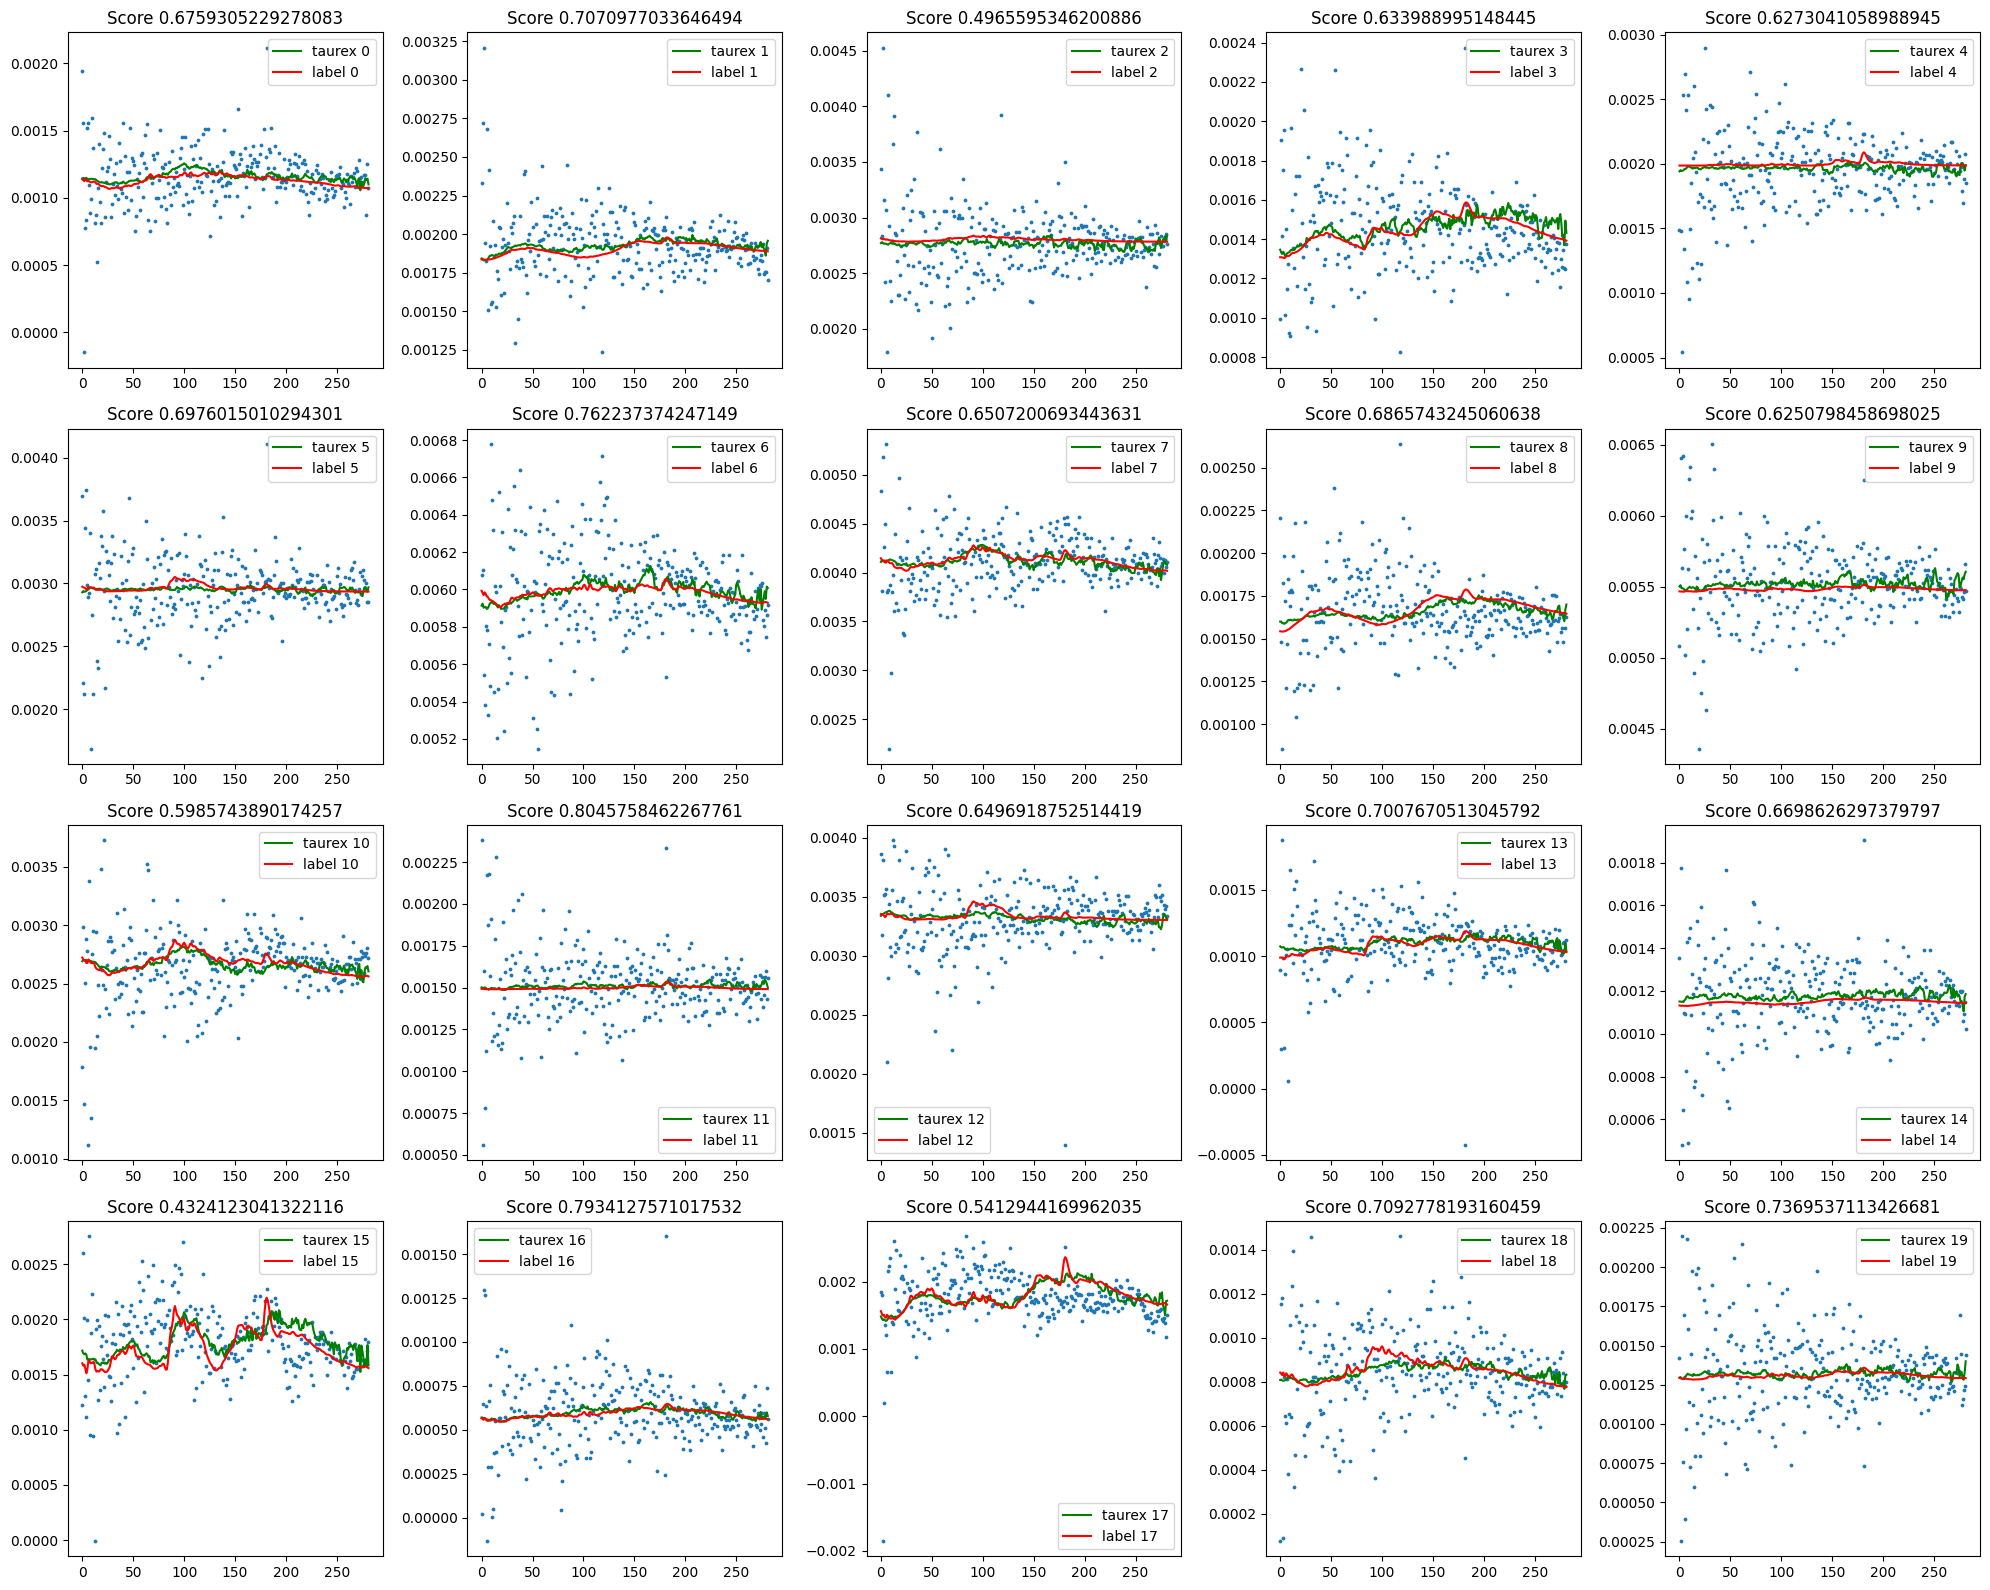

In [25]:
import numpy as np
import matplotlib.pyplot as plt

if dataset == "train" and len(adc_info) <= 100:

    n_rows = (len(adc_info) - 1) // 5 + 1
    fig, axes = plt.subplots(
        n_rows, 5, figsize=(20, n_rows * 4)
    )  

    label = pd.read_csv("/kaggle/input/ariel-data-challenge-2024/train_labels.csv")
    
    label = label.to_numpy()[:, 1:]


    for idx in range(len(adc_info)):
        if len(adc_info) < 5:
            ax = axes[idx]
        else:
            ax = axes[idx // 5, idx % 5]  
        dip = dip_list[idx]
        pred = all_s[idx, 1:]
        l = label[idx, 1:]
        ax.scatter(np.arange(len(dip)), dip[::-1], s=3)
        ax.plot(np.arange(len(pred)), pred, label=f"taurex {idx}", color="green")
        ax.plot(np.arange(len(l)), l, label=f"label {idx}", color="red")
        ax.legend()
        score_idx = score(label[idx : idx + 1], sub[idx : idx + 1])
        ax.set_title(f"Score {score_idx}")  


    plt.tight_layout()

    plt.savefig("combined_plots.png")

    plt.show()

In [26]:
ss = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/sample_submission.csv')
sigma = all_sigma
pred = all_s.clip(0) 
submission = pd.DataFrame(np.concatenate([pred,sigma], axis=1), columns=ss.columns[1:])
submission.index = adc_info.index
submission.to_csv('submission.csv')
submission

,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
planet_id,,,,,,,,,,,,,,,,,,,,,
785834,0.001029,0.001144,0.001148,0.001144,0.001145,0.001149,0.001139,0.001138,0.001140,0.001140,...,0.000035,0.000035,0.000035,0.000035,0.000035,0.000035,0.000035,0.000035,0.000035,0.000035
14485303,0.001817,0.001841,0.001840,0.001829,0.001832,0.001828,0.001831,0.001836,0.001848,0.001859,...,0.000029,0.000029,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030
17002355,0.002674,0.002771,0.002779,0.002771,0.002764,0.002767,0.002765,0.002761,0.002757,0.002765,...,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025
24135240,0.001283,0.001346,0.001332,0.001325,0.001336,0.001325,0.001312,0.001322,0.001328,0.001331,...,0.000037,0.000037,0.000037,0.000038,0.000038,0.000038,0.000038,0.000038,0.000038,0.000038
25070640,0.001887,0.001943,0.001951,0.001944,0.001947,0.001951,0.001960,0.001961,0.001969,0.001979,...,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032
26372015,0.002880,0.002930,0.002939,0.002934,0.002936,0.002940,0.002949,0.002952,0.002961,0.002968,...,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026
29348276,0.005842,0.005914,0.005924,0.005902,0.005906,0.005907,0.005896,0.005899,0.005909,0.005924,...,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000043
33548644,0.003912,0.004108,0.004125,0.004115,0.004112,0.004123,0.004117,0.004113,0.004119,0.004130,...,0.000052,0.000052,0.000052,0.000052,0.000052,0.000053,0.000053,0.000053,0.000053,0.000053
50637799,0.001582,0.001600,0.001600,0.001591,0.001590,0.001587,0.001590,0.001593,0.001601,0.001609,...,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.000042
